In [8]:
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

In [9]:
train_data = pd.read_csv('C:/Users/hp/Desktop/finalyear/RNN-LDA-Topic-Labeling-main/Initiation-practice/CSV/T.csv')

print(train_data.shape)
train_data.head(5)

(3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [10]:
# check if there's missing data
train_data.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [12]:
document_lengths = np.array(list(map(len, train_data.OriginalTweet
.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 32.6216429699842.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 79.


### fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [13]:
print("There are {} documents with over 150 words.".format(sum(document_lengths > 150)))

shorter_documents = document_lengths[document_lengths <= 150]

There are 0 documents with over 150 words.


In [14]:
# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'https'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'OriginalTweet'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'OriginalTweet'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 1551 words with characters with an ordinal >= 128 in the train data.


In [15]:
def get_good_tokens(OriginalTweet):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), OriginalTweet))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [22]:

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    #df['OriginalTweet'] = df.OriginalTweet.str.lower()
    #df['OriginalTweet'] = df.OriginalTweet.str.split('.')  # split texts into individual sentences
    df['tokenized_OriginalTweet'] = list(map(lambda OriginalTweet:
                                         list(map(nltk.word_tokenize, OriginalTweet)),df.OriginalTweet))# tokenize sentences
                                  
    df['tokenized_sentences'] = list(map(lambda OriginalTweet:
                                         list(map(get_good_tokens, OriginalTweet)),df.tokenized_sentences))  # remove unwanted characters
                                         
    df['tokenized_sentences'] = list(map(lambda OriginalTweet:
                                         list(filter(lambda lst: lst, OriginalTweet)),df.tokenized_sentences))  # remove empty lists
                                         

w2v_preprocessing(train_data)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\hp/nltk_data'
    - 'C:\\Users\\hp\\anaconda3\\nltk_data'
    - 'C:\\Users\\hp\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\hp\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\hp\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [48]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['OriginalTweet'] = df.OriginalTweet.str.lower()
    #df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    

w2v_preprocessing(train_data)

In [46]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot()
ax.set_title("Word Frequencies", fontsize=16);

NameError: name 'OriginalTweet' is not defined

AttributeError: 'numpy.int32' object has no attribute 'texts'

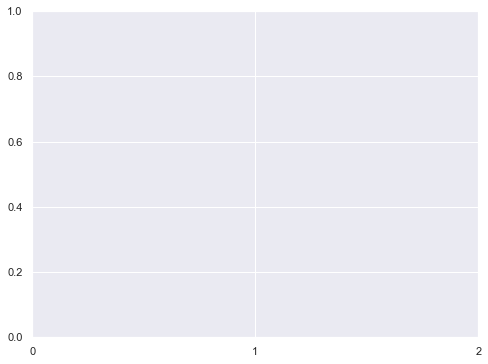

In [44]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

OriginalTweet_processed = train_data.OriginalTweet.count()

#ax.bar(range(3), OriginalTweet)
ax.set_xticks(range(3))
#ax.set_xticklabels(OriginalTweet_processed.index, fontsize=16)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g'], OriginalTweet_processed.texts):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')